# Import Libraries

In [4]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader

import optuna

In [5]:
# device
print(torch.cuda.is_available())
print('device name:', torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

print_gpu_memory()

True
device name: NVIDIA GeForce RTX 3050 Laptop GPU
Allocated memory: 0.00 MB
Cached memory: 0.00 MB


# RGB Model

In [30]:
# hyperparameters
in_channels = 3
num_classes = 3
batch_size = 32

## Load Dataset

In [31]:
class DrowningDataset(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['file_path'].str.contains(rf'\\{split}\\|/{split}/', regex=True)]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]

        # Use PIL to open image
        image = Image.open(img_path).convert("RGB")  
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label


In [32]:
# Define transformations for training with augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation (no augmentations)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'train', transform = train_transform)
val_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'val', transform = val_transform)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([32, 3, 32, 32])


## CNN Model

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_RGB(nn.Module):
    def __init__(self):
        super(CNN_RGB, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 3)  # Flattened size = 400, output = 3

        # Activation
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.pool(F.silu(self.conv1(x)))  
        x = self.pool(F.silu(self.conv2(x)))  
        x = self.flat(x)
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)  

        return x

# Create model instance
cnn_rgb_model = CNN_RGB()
print(cnn_rgb_model)


CNN_RGB(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=3, bias=True)
  (activation): SiLU()
)


## Training Loop

In [34]:
# See total number of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_rgb_model.to(device)
print("Params start",count_parameters(cnn_rgb_model))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_rgb_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Variables to track the best model
best_val_acc = 0.0
best_epoch = 0
best_metrics = {}

start = time.perf_counter()

for epoch in range(num_epochs):
    cnn_rgb_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_rgb_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    cnn_rgb_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_rgb_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store actual labels
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Normalize test loss
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_metrics = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

        torch.save(cnn_rgb_model.state_dict(), "cnn_rgb_model.pth")

total_time = time.perf_counter() - start

cnn_rgb_model.training_time = total_time/60 /num_epochs
print("\nTraining complete! ✅")
print(f"Total time (min) {total_time/60:.2f}",)
print("\nBest Model Summary:")
print(f"Epoch: {best_metrics['epoch']}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}, Train Acc: {best_metrics['train_acc']:.2f}%")
print(f"Val Loss: {best_metrics['val_loss']:.4f}, Val Acc: {best_metrics['val_acc']:.2f}%")
print(f"Precision: {best_metrics['precision']:.2f}, Recall: {best_metrics['recall']:.2f}, F1 Score: {best_metrics['f1_score']:.2f}")

Params start 4075


100%|██████████| 114/114 [00:04<00:00, 24.42it/s]


Epoch [1/10] - Train Loss: 0.6316, Train Acc: 73.97%
Val loss: 0.3328, Val Acc: 88.89%, Precision: 0.89, Recall: 0.88, F1 Score: 0.89


100%|██████████| 114/114 [00:02<00:00, 48.07it/s]


Epoch [2/10] - Train Loss: 0.4003, Train Acc: 84.86%
Val loss: 0.2189, Val Acc: 92.65%, Precision: 0.93, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:02<00:00, 43.75it/s]


Epoch [3/10] - Train Loss: 0.3395, Train Acc: 87.79%
Val loss: 0.1857, Val Acc: 93.78%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


100%|██████████| 114/114 [00:02<00:00, 49.67it/s]


Epoch [4/10] - Train Loss: 0.3060, Train Acc: 89.26%
Val loss: 0.1700, Val Acc: 94.00%, Precision: 0.94, Recall: 0.94, F1 Score: 0.94


100%|██████████| 114/114 [00:02<00:00, 47.03it/s]


Epoch [5/10] - Train Loss: 0.2854, Train Acc: 89.95%
Val loss: 0.1542, Val Acc: 94.69%, Precision: 0.95, Recall: 0.94, F1 Score: 0.94


100%|██████████| 114/114 [00:02<00:00, 48.95it/s]


Epoch [6/10] - Train Loss: 0.2683, Train Acc: 90.82%
Val loss: 0.1440, Val Acc: 95.25%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:02<00:00, 47.02it/s]


Epoch [7/10] - Train Loss: 0.2598, Train Acc: 90.73%
Val loss: 0.1278, Val Acc: 95.72%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 44.74it/s]


Epoch [8/10] - Train Loss: 0.2459, Train Acc: 91.45%
Val loss: 0.1326, Val Acc: 95.72%, Precision: 0.96, Recall: 0.95, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 44.31it/s]


Epoch [9/10] - Train Loss: 0.2351, Train Acc: 91.88%
Val loss: 0.1363, Val Acc: 95.66%, Precision: 0.96, Recall: 0.95, F1 Score: 0.96


100%|██████████| 114/114 [00:03<00:00, 32.13it/s]

Epoch [10/10] - Train Loss: 0.2290, Train Acc: 92.17%
Val loss: 0.1205, Val Acc: 96.30%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96

Training complete! ✅
Total time (min) 5.31

Best Model Summary:
Epoch: 10
Train Loss: 0.2290, Train Acc: 92.17%
Val Loss: 0.1205, Val Acc: 96.30%
Precision: 0.96, Recall: 0.96, F1 Score: 0.96


In [35]:
# Save metrics to a CSV file
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "precisions": precisions,
    "recalls": recalls,
    "f1_scores": f1_scores,
}
df = pd.DataFrame(metrics)
df.to_csv("cnn_rgb_training_metrics.csv", index=False)

print("Metrics saved as 'cnn_rgb_training_metrics.csv'")

Metrics saved as 'cnn_rgb_training_metrics.csv'


# Grayscale Model

In [36]:
# hyperparameters
in_channels = 1
num_classes = 3
batch_size = 32

## Load Dataset

In [37]:
class DrowningDataset(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['file_path'].str.contains(rf'\\{split}\\|/{split}/', regex=True)]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]

        # Use PIL to open image
        image = Image.open(img_path).convert("L")  
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [38]:
# Define transformations for training with augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Grayscale Normalization
])

# Define transformations for validation (no augmentations)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Grayscale Normalization
])

train_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'train', transform = train_transform)
val_ds = DrowningDataset(csv_file = 'drowning_dataset_32.csv', split = 'val', transform = val_transform)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([32, 1, 32, 32])


## CNN Grayscale Model

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Grayscale(nn.Module):
    def __init__(self):
        super(CNN_Grayscale, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 3)  # Flattened size = 400, output = 3

        # Activation
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.pool(F.silu(self.conv1(x)))  
        x = self.pool(F.silu(self.conv2(x)))  
        x = self.flat(x)
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)  

        return x

# Create model instance
cnn_grayscale_model = CNN_Grayscale()
print(cnn_grayscale_model)


CNN_Grayscale(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=3, bias=True)
  (activation): SiLU()
)


## Create and Train Model

In [40]:
# See total number of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_grayscale_model.to(device)
print("Params start",count_parameters(cnn_grayscale_model))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_grayscale_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Variables to track the best model
best_val_acc = 0.0
best_epoch = 0
best_metrics = {}

start = time.perf_counter()

for epoch in range(num_epochs):
    cnn_grayscale_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_grayscale_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    cnn_grayscale_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_grayscale_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store actual labels
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Normalize test loss
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_metrics = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

        torch.save(cnn_grayscale_model.state_dict(), "cnn_grayscale_model.pth")

total_time = time.perf_counter() - start

cnn_grayscale_model.training_time = total_time/60 /num_epochs
print("\nTraining complete! ✅")
print(f"Total time (min) {total_time/60:.2f}",)
print("\nBest Model Summary:")
print(f"Epoch: {best_metrics['epoch']}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}, Train Acc: {best_metrics['train_acc']:.2f}%")
print(f"Val Loss: {best_metrics['val_loss']:.4f}, Val Acc: {best_metrics['val_acc']:.2f}%")
print(f"Precision: {best_metrics['precision']:.2f}, Recall: {best_metrics['recall']:.2f}, F1 Score: {best_metrics['f1_score']:.2f}")

Params start 3775


100%|██████████| 114/114 [00:02<00:00, 44.91it/s]


Epoch [1/10] - Train Loss: 0.6881, Train Acc: 70.51%
Val loss: 0.3865, Val Acc: 87.01%, Precision: 0.87, Recall: 0.87, F1 Score: 0.87


100%|██████████| 114/114 [00:02<00:00, 53.16it/s]


Epoch [2/10] - Train Loss: 0.4693, Train Acc: 82.19%
Val loss: 0.3005, Val Acc: 89.41%, Precision: 0.89, Recall: 0.89, F1 Score: 0.89


100%|██████████| 114/114 [00:02<00:00, 52.10it/s]


Epoch [3/10] - Train Loss: 0.4251, Train Acc: 84.05%
Val loss: 0.2858, Val Acc: 90.77%, Precision: 0.91, Recall: 0.90, F1 Score: 0.90


100%|██████████| 114/114 [00:03<00:00, 36.63it/s]


Epoch [4/10] - Train Loss: 0.3963, Train Acc: 85.56%
Val loss: 0.2589, Val Acc: 91.27%, Precision: 0.91, Recall: 0.91, F1 Score: 0.91


100%|██████████| 114/114 [00:03<00:00, 34.71it/s]


Epoch [5/10] - Train Loss: 0.3756, Train Acc: 86.50%
Val loss: 0.2410, Val Acc: 91.85%, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:02<00:00, 41.90it/s]


Epoch [6/10] - Train Loss: 0.3701, Train Acc: 86.43%
Val loss: 0.2302, Val Acc: 92.18%, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:02<00:00, 42.44it/s]


Epoch [7/10] - Train Loss: 0.3589, Train Acc: 87.22%
Val loss: 0.2303, Val Acc: 91.98%, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:03<00:00, 30.00it/s]


Epoch [8/10] - Train Loss: 0.3427, Train Acc: 87.53%
Val loss: 0.2220, Val Acc: 92.65%, Precision: 0.92, Recall: 0.93, F1 Score: 0.92


100%|██████████| 114/114 [00:04<00:00, 27.66it/s]


Epoch [9/10] - Train Loss: 0.3408, Train Acc: 87.78%
Val loss: 0.2151, Val Acc: 92.62%, Precision: 0.92, Recall: 0.92, F1 Score: 0.92


100%|██████████| 114/114 [00:02<00:00, 53.95it/s]

Epoch [10/10] - Train Loss: 0.3394, Train Acc: 87.82%
Val loss: 0.2124, Val Acc: 93.01%, Precision: 0.93, Recall: 0.93, F1 Score: 0.93

Training complete! ✅
Total time (min) 4.88

Best Model Summary:
Epoch: 10
Train Loss: 0.3394, Train Acc: 87.82%
Val Loss: 0.2124, Val Acc: 93.01%
Precision: 0.93, Recall: 0.93, F1 Score: 0.93


In [41]:
# Save metrics to a CSV file
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "precisions": precisions,
    "recalls": recalls,
    "f1_scores": f1_scores,
}
df = pd.DataFrame(metrics)
df.to_csv("cnn_grayscale_training_metrics.csv", index=False)

print("Metrics saved as 'cnn_grayscale_training_metrics.csv'")

Metrics saved as 'cnn_grayscale_training_metrics.csv'


# Inference

C:\Users\jojoa\AppData\Local\Temp\ipykernel_22832\3371142403.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

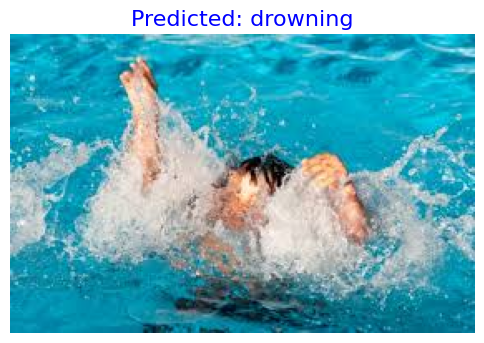

In [43]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class label mapping
class_labels = {0: 'swimming', 1: 'tread_water', 2: 'drowning'}

# Load and preprocess the test image
image_path = "tester5.jpg"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to match your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Match the normalization used during training
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "cnn_rgb_model.pth"

# Initialize model
model = CNN_RGB()
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Perform prediction
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = class_labels.get(pred_class, "Unknown")

# Visualization with predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {pred_label}", fontsize=16, color='blue')
plt.axis('off')
plt.show()

C:\Users\jojoa\AppData\Local\Temp\ipykernel_22832\2718848316.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

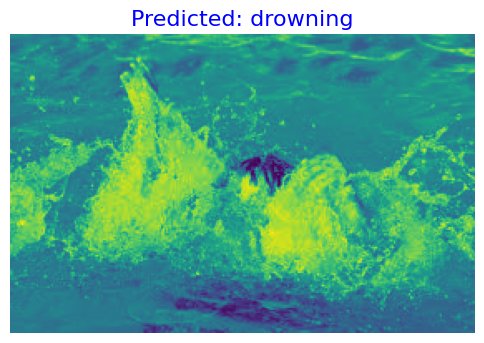

In [44]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class label mapping
class_labels = {0: 'swimming', 1: 'tread_water', 2: 'drowning'}

# Load and preprocess the test image
image_path = "tester5.jpg"
image = Image.open(image_path).convert("L")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to match your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalisation
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "cnn_grayscale_model.pth"

# Initialize model
model = CNN_Grayscale()
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Perform prediction
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = class_labels.get(pred_class, "Unknown")

# Visualization with predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {pred_label}", fontsize=16, color='blue')
plt.axis('off')
plt.show()

C:\Users\jojoa\AppData\Local\Temp\ipykernel_22832\2197186633.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

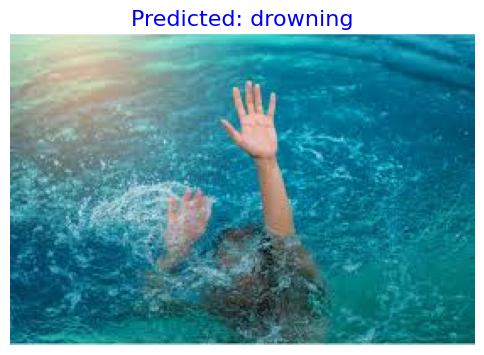

In [45]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class label mapping
class_labels = {0: 'swimming', 1: 'tread_water', 2: 'drowning'}

# Load and preprocess the test image
image_path = "tester4.jpg"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to match your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Match the normalization used during training
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "cnn_rgb_model.pth"

# Initialize model
model = CNN_RGB()
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Perform prediction
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = class_labels.get(pred_class, "Unknown")

# Visualization with predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {pred_label}", fontsize=16, color='blue')
plt.axis('off')
plt.show()

C:\Users\jojoa\AppData\Local\Temp\ipykernel_22832\3846582299.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

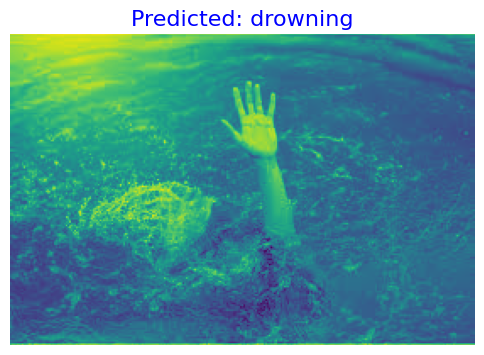

In [46]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Class label mapping
class_labels = {0: 'swimming', 1: 'tread_water', 2: 'drowning'}

# Load and preprocess the test image
image_path = "tester4.jpg"
image = Image.open(image_path).convert("L")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Adjust to match your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalisation
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "cnn_grayscale_model.pth"

# Initialize model
model = CNN_Grayscale()
model.load_state_dict(torch.load(model_path, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Perform prediction
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    pred_label = class_labels.get(pred_class, "Unknown")

# Visualization with predicted label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Predicted: {pred_label}", fontsize=16, color='blue')
plt.axis('off')
plt.show()

# Hyperparameter Tuning

In [20]:
num_classes = 3
in_channels = 3
num_epochs_tune = 5 # Number of epochs for each tuning trials
n_trials = 20 # Number of Optuna trials to run
image_size = 32

## Load Dataset

In [26]:
class DrowningDataset(Dataset):
    def __init__(self, csv_file, split, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['file_path'].str.contains(rf'\\{split}\\|/{split}/', regex=True)]
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]

        # Use PIL to open image
        image = Image.open(img_path).convert("RGB")  
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return image, y_label

# Define transformations for training with augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transformations for validation (no augmentations)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- DataLoader Function ---
def get_dataloaders(batch_size):
    train_ds = DrowningDataset(csv_file= 'drowning_dataset_32.csv', split='train', transform=train_transform)
    val_ds = DrowningDataset(csv_file= 'drowning_dataset_32.csv', split='val', transform=val_transform)

    # Filter out None samples if any image files were not found
    train_ds.annotations = train_ds.annotations.dropna()
    val_ds.annotations = val_ds.annotations.dropna()
    
    # Custom collate function to handle potential None values from getitem
    def collate_fn(batch):
        batch = list(filter(lambda x: x[0] is not None, batch))
        if not batch:
             return torch.Tensor(), torch.Tensor() # Return empty tensors if batch is empty
        return torch.utils.data.dataloader.default_collate(batch)

    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

## Define Model

In [22]:
class CNN_RGB_Tune(nn.Module):
    # Same as previous script - no changes needed here
    def __init__(self, conv1_out=6, conv2_out=16, kernel_s=5):
        super(CNN_RGB_Tune, self).__init__()
        padding_val = kernel_s // 2

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=conv1_out, kernel_size=kernel_s, padding=padding_val)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        conv1_out_dim = (image_size + 2 * padding_val - kernel_s) // 1 + 1
        pool1_out_dim = conv1_out_dim // 2

        self.conv2 = nn.Conv2d(in_channels=conv1_out, out_channels=conv2_out, kernel_size=kernel_s, padding=padding_val)
        
        conv2_out_dim = (pool1_out_dim + 2 * padding_val - kernel_s) // 1 + 1
        pool2_out_dim = conv2_out_dim // 2
        fc1_in_features = conv2_out * pool2_out_dim * pool2_out_dim

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(fc1_in_features, num_classes)
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.pool(F.silu(self.conv1(x)))
        x = self.pool(F.silu(self.conv2(x)))
        x = self.flat(x)
        x = self.fc1(x)
        return x

## Test and Evaluate Function

In [23]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                if images is None or images.nelement() == 0: continue # Skip empty batches
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        print(f"Epoch {epoch+1} Val Acc: {val_acc:.2f}%")
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

In [24]:
# --- Optuna Objective Function (CNN RGB) ---
def objective_cnn_rgb(trial: optuna.trial.Trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    conv1_out = trial.suggest_int("conv1_out", 4, 12)
    conv2_out = trial.suggest_int("conv2_out", 8, 24)
    kernel_s = trial.suggest_categorical("kernel_size", [3, 5])

    # Get DataLoaders
    train_loader, val_loader = get_dataloaders(batch_size)

    # Create model
    model = CNN_RGB_Tune(conv1_out=conv1_out, conv2_out=conv2_out, kernel_s=kernel_s).to(device)

    # Create optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else: # SGD
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9) # Added momentum for SGD

    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    validation_accuracy = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs_tune)

    return validation_accuracy

In [25]:
# --- Trigger Tuning ---
study_cnn = optuna.create_study(direction="maximize", study_name="cnn_rgb_tuning")
study_cnn.optimize(objective_cnn_rgb, n_trials=n_trials)

print("\n--- CNN RGB Tuning Results ---")
print(f"Number of finished trials: {len(study_cnn.trials)}")

best_trial_cnn = study_cnn.best_trial
print(f"Best trial value (Validation Accuracy): {best_trial_cnn.value:.4f}%")
print("Best hyperparameters:")
for key, value in best_trial_cnn.params.items():
    print(f"  {key}: {value}")

[I 2025-04-30 10:12:47,721] A new study created in memory with name: cnn_rgb_tuning
Epoch 1/5 [Val]: 100%|██████████| 227/227 [00:03<00:00, 63.90it/s]


Epoch 1 Val Acc: 75.46%


Epoch 2/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 106.14it/s]


Epoch 2 Val Acc: 79.60%


Epoch 3/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 107.42it/s]


Epoch 3 Val Acc: 84.96%


Epoch 4/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 107.15it/s]


Epoch 4 Val Acc: 88.11%


Epoch 5/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 106.49it/s]
[I 2025-04-30 10:15:23,620] Trial 0 finished with value: 89.55223880597015 and parameters: {'lr': 0.00010824788898819154, 'optimizer': 'Adam', 'batch_size': 16, 'conv1_out': 12, 'conv2_out': 24, 'kernel_size': 3}. Best is trial 0 with value: 89.55223880597015.


Epoch 5 Val Acc: 89.55%


Epoch 1/5 [Val]: 100%|██████████| 227/227 [00:03<00:00, 70.16it/s]


Epoch 1 Val Acc: 58.82%


Epoch 2/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 96.90it/s] 


Epoch 2 Val Acc: 72.47%


Epoch 3/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 103.70it/s]


Epoch 3 Val Acc: 82.31%


Epoch 4/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 100.42it/s]


Epoch 4 Val Acc: 88.61%


Epoch 5/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 105.25it/s]
[I 2025-04-30 10:17:55,120] Trial 1 finished with value: 88.61249309010503 and parameters: {'lr': 0.000494152103572185, 'optimizer': 'SGD', 'batch_size': 16, 'conv1_out': 8, 'conv2_out': 10, 'kernel_size': 5}. Best is trial 0 with value: 89.55223880597015.


Epoch 5 Val Acc: 88.11%


Epoch 1/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 103.98it/s]


Epoch 1 Val Acc: 56.19%


Epoch 2/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 103.36it/s]


Epoch 2 Val Acc: 69.82%


Epoch 3/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 103.14it/s]


Epoch 3 Val Acc: 71.97%


Epoch 4/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 102.87it/s]


Epoch 4 Val Acc: 74.88%


Epoch 5/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 97.23it/s] 
[I 2025-04-30 10:20:25,807] Trial 2 finished with value: 79.18739635157546 and parameters: {'lr': 0.00018715441811433092, 'optimizer': 'SGD', 'batch_size': 16, 'conv1_out': 9, 'conv2_out': 21, 'kernel_size': 5}. Best is trial 0 with value: 89.55223880597015.


Epoch 5 Val Acc: 79.19%


Epoch 1/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 102.85it/s]


Epoch 1 Val Acc: 93.15%


Epoch 2/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 102.11it/s]


Epoch 2 Val Acc: 85.43%


Epoch 3/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 105.19it/s]


Epoch 3 Val Acc: 93.34%


Epoch 4/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 106.04it/s]


Epoch 4 Val Acc: 56.14%


Epoch 5/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 105.21it/s]
[I 2025-04-30 10:22:57,343] Trial 3 finished with value: 93.338861249309 and parameters: {'lr': 0.007948817515351134, 'optimizer': 'Adam', 'batch_size': 16, 'conv1_out': 7, 'conv2_out': 23, 'kernel_size': 5}. Best is trial 3 with value: 93.338861249309.


Epoch 5 Val Acc: 66.36%


Epoch 1/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 101.03it/s]


Epoch 1 Val Acc: 87.95%


Epoch 2/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 99.08it/s] 


Epoch 2 Val Acc: 92.48%


Epoch 3/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 104.92it/s]


Epoch 3 Val Acc: 94.42%


Epoch 4/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 98.96it/s] 


Epoch 4 Val Acc: 94.80%


Epoch 5/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 103.73it/s]
[I 2025-04-30 10:25:26,987] Trial 4 finished with value: 95.05251520176893 and parameters: {'lr': 0.0003227980230604173, 'optimizer': 'Adam', 'batch_size': 16, 'conv1_out': 12, 'conv2_out': 16, 'kernel_size': 5}. Best is trial 4 with value: 95.05251520176893.


Epoch 5 Val Acc: 95.05%


Epoch 1/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.49it/s]


Epoch 1 Val Acc: 72.72%


Epoch 2/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.35it/s]


Epoch 2 Val Acc: 76.87%


Epoch 3/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 27.36it/s]


Epoch 3 Val Acc: 78.80%


Epoch 4/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.50it/s]


Epoch 4 Val Acc: 82.28%


Epoch 5/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.41it/s]
[I 2025-04-30 10:27:42,465] Trial 5 finished with value: 84.7705914870094 and parameters: {'lr': 0.000199025090717033, 'optimizer': 'Adam', 'batch_size': 64, 'conv1_out': 9, 'conv2_out': 23, 'kernel_size': 3}. Best is trial 4 with value: 95.05251520176893.


Epoch 5 Val Acc: 84.77%


Epoch 1/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 96.44it/s] 


Epoch 1 Val Acc: 74.46%


Epoch 2/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 100.33it/s]


Epoch 2 Val Acc: 77.94%


Epoch 3/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 104.07it/s]


Epoch 3 Val Acc: 81.29%


Epoch 4/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 105.74it/s]


Epoch 4 Val Acc: 84.52%


Epoch 5/5 [Val]: 100%|██████████| 227/227 [00:02<00:00, 105.01it/s]
[I 2025-04-30 10:30:10,229] Trial 6 finished with value: 86.5118850193477 and parameters: {'lr': 0.00010477440779707788, 'optimizer': 'Adam', 'batch_size': 16, 'conv1_out': 11, 'conv2_out': 20, 'kernel_size': 3}. Best is trial 4 with value: 95.05251520176893.


Epoch 5 Val Acc: 86.51%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.54it/s]


Epoch 1 Val Acc: 94.20%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.81it/s]


Epoch 2 Val Acc: 95.00%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.57it/s]


Epoch 3 Val Acc: 95.77%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.58it/s]


Epoch 4 Val Acc: 96.16%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.59it/s]
[I 2025-04-30 10:32:30,237] Trial 7 finished with value: 96.18573797678275 and parameters: {'lr': 0.00244884791081617, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 12, 'conv2_out': 23, 'kernel_size': 5}. Best is trial 7 with value: 96.18573797678275.


Epoch 5 Val Acc: 96.19%


Epoch 1/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 27.12it/s]


Epoch 1 Val Acc: 47.48%


Epoch 2/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.43it/s]


Epoch 2 Val Acc: 50.11%


Epoch 3/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.49it/s]


Epoch 3 Val Acc: 54.37%


Epoch 4/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 27.45it/s]


Epoch 4 Val Acc: 57.21%


Epoch 5/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.44it/s]
[I 2025-04-30 10:34:44,939] Trial 8 finished with value: 67.55113322277501 and parameters: {'lr': 0.000411831516831946, 'optimizer': 'SGD', 'batch_size': 64, 'conv1_out': 10, 'conv2_out': 9, 'kernel_size': 5}. Best is trial 7 with value: 96.18573797678275.


Epoch 5 Val Acc: 67.55%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.52it/s]


Epoch 1 Val Acc: 71.17%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.46it/s]


Epoch 2 Val Acc: 75.43%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.06it/s]


Epoch 3 Val Acc: 81.92%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.75it/s]


Epoch 4 Val Acc: 88.36%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.60it/s]
[I 2025-04-30 10:37:04,123] Trial 9 finished with value: 90.16030956329463 and parameters: {'lr': 0.0011061488688728336, 'optimizer': 'SGD', 'batch_size': 32, 'conv1_out': 4, 'conv2_out': 15, 'kernel_size': 3}. Best is trial 7 with value: 96.18573797678275.


Epoch 5 Val Acc: 90.16%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.39it/s]


Epoch 1 Val Acc: 94.47%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.30it/s]


Epoch 2 Val Acc: 94.31%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.65it/s]


Epoch 3 Val Acc: 95.80%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.64it/s]


Epoch 4 Val Acc: 96.21%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.58it/s]
[I 2025-04-30 10:39:25,463] Trial 10 finished with value: 96.65561083471532 and parameters: {'lr': 0.003004031941485636, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 6, 'conv2_out': 19, 'kernel_size': 5}. Best is trial 10 with value: 96.65561083471532.


Epoch 5 Val Acc: 96.66%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 52.47it/s]


Epoch 1 Val Acc: 93.67%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.88it/s]


Epoch 2 Val Acc: 94.31%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.92it/s]


Epoch 3 Val Acc: 96.66%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.77it/s]


Epoch 4 Val Acc: 95.94%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 52.69it/s]
[I 2025-04-30 10:41:45,533] Trial 11 finished with value: 96.65561083471532 and parameters: {'lr': 0.0029750944055784395, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 6, 'conv2_out': 19, 'kernel_size': 5}. Best is trial 10 with value: 96.65561083471532.


Epoch 5 Val Acc: 95.91%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.05it/s]


Epoch 1 Val Acc: 94.61%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.48it/s]


Epoch 2 Val Acc: 95.11%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.36it/s]


Epoch 3 Val Acc: 96.21%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 52.54it/s]


Epoch 4 Val Acc: 95.22%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.77it/s]
[I 2025-04-30 10:44:06,001] Trial 12 finished with value: 96.21337755666114 and parameters: {'lr': 0.004699395249852076, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 5, 'conv2_out': 18, 'kernel_size': 5}. Best is trial 10 with value: 96.65561083471532.


Epoch 5 Val Acc: 95.30%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.50it/s]


Epoch 1 Val Acc: 93.78%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.13it/s]


Epoch 2 Val Acc: 92.81%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 51.49it/s]


Epoch 3 Val Acc: 94.67%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.14it/s]


Epoch 4 Val Acc: 96.35%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 49.05it/s]
[I 2025-04-30 10:46:26,752] Trial 13 finished with value: 96.8767274737424 and parameters: {'lr': 0.0021515292646880715, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 6, 'conv2_out': 13, 'kernel_size': 5}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 96.88%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.87it/s]


Epoch 1 Val Acc: 91.79%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 44.81it/s]


Epoch 2 Val Acc: 94.00%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 51.45it/s]


Epoch 3 Val Acc: 95.25%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.26it/s]


Epoch 4 Val Acc: 95.88%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.83it/s]
[I 2025-04-30 10:48:48,687] Trial 14 finished with value: 96.0751796572692 and parameters: {'lr': 0.001332308934297572, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 6, 'conv2_out': 13, 'kernel_size': 5}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 96.08%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.44it/s]


Epoch 1 Val Acc: 93.26%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.11it/s]


Epoch 2 Val Acc: 94.58%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.19it/s]


Epoch 3 Val Acc: 95.38%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.99it/s]


Epoch 4 Val Acc: 95.96%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.27it/s]
[I 2025-04-30 10:51:08,847] Trial 15 finished with value: 96.40685461580983 and parameters: {'lr': 0.0020321435680153216, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 4, 'conv2_out': 12, 'kernel_size': 5}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 96.41%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 52.21it/s]


Epoch 1 Val Acc: 85.66%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.35it/s]


Epoch 2 Val Acc: 91.68%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.56it/s]


Epoch 3 Val Acc: 93.50%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.48it/s]


Epoch 4 Val Acc: 94.58%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 52.26it/s]
[I 2025-04-30 10:53:29,469] Trial 16 finished with value: 94.58264234383637 and parameters: {'lr': 0.008141269442657882, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 7, 'conv2_out': 14, 'kernel_size': 5}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 90.71%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.81it/s]


Epoch 1 Val Acc: 94.36%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 54.78it/s]


Epoch 2 Val Acc: 94.00%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.64it/s]


Epoch 3 Val Acc: 95.36%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 52.36it/s]


Epoch 4 Val Acc: 95.61%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.02it/s]
[I 2025-04-30 10:55:50,865] Trial 17 finished with value: 95.60530679933665 and parameters: {'lr': 0.004605131487701105, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 6, 'conv2_out': 17, 'kernel_size': 5}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 95.52%


Epoch 1/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.27it/s]


Epoch 1 Val Acc: 38.17%


Epoch 2/5 [Val]: 100%|██████████| 57/57 [00:01<00:00, 28.53it/s]


Epoch 2 Val Acc: 38.17%


Epoch 3/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 26.21it/s]


Epoch 3 Val Acc: 38.17%


Epoch 4/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.14it/s]


Epoch 4 Val Acc: 39.05%


Epoch 5/5 [Val]: 100%|██████████| 57/57 [00:02<00:00, 28.36it/s]
[I 2025-04-30 10:58:07,901] Trial 18 finished with value: 54.06301824212272 and parameters: {'lr': 0.000683465802578812, 'optimizer': 'SGD', 'batch_size': 64, 'conv1_out': 5, 'conv2_out': 12, 'kernel_size': 3}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 54.06%


Epoch 1/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.78it/s]


Epoch 1 Val Acc: 90.22%


Epoch 2/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 53.72it/s]


Epoch 2 Val Acc: 93.75%


Epoch 3/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.14it/s]


Epoch 3 Val Acc: 94.75%


Epoch 4/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 55.36it/s]


Epoch 4 Val Acc: 95.25%


Epoch 5/5 [Val]: 100%|██████████| 114/114 [00:02<00:00, 56.06it/s]
[I 2025-04-30 11:00:28,993] Trial 19 finished with value: 95.24599226091763 and parameters: {'lr': 0.001382886201280608, 'optimizer': 'Adam', 'batch_size': 32, 'conv1_out': 7, 'conv2_out': 11, 'kernel_size': 5}. Best is trial 13 with value: 96.8767274737424.


Epoch 5 Val Acc: 94.44%

--- CNN RGB Tuning Results ---
Number of finished trials: 20
Best trial value (Validation Accuracy): 96.8767%
Best hyperparameters:
  lr: 0.0021515292646880715
  optimizer: Adam
  batch_size: 32
  conv1_out: 6
  conv2_out: 13
  kernel_size: 5


## Train Model Using Best Params

In [32]:
# Best Params
lr = 0.0021515292646880715
optimizer = 'Adam'
batch_size = 32
conv1_out = 6
conv2_out = 13
kernel_size = 5

### Training Loop

In [34]:
# See total number of params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Get DataLoaders
train_loader, val_loader = get_dataloaders(batch_size)

# Move model to GPU (if available)
best_model = CNN_RGB_Tune(conv1_out=conv1_out, conv2_out=conv2_out, kernel_s=kernel_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)
print("Params start",count_parameters(best_model))

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=lr)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Variables to track the best model
best_val_acc = 0.0
best_epoch = 0
best_metrics = {}

start = time.perf_counter()

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation loop
    best_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store actual labels
            
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Normalize test loss
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Compute precision, recall, and F1-score
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Store metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_metrics = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }

        torch.save(best_model.state_dict(), "fine_tuned_cnn.pth")

total_time = time.perf_counter() - start

best_model.training_time = total_time/60 /num_epochs
print("\nTraining complete! ✅")
print(f"Total time (min) {total_time/60:.2f}",)
print("\nBest Model Summary:")
print(f"Epoch: {best_metrics['epoch']}")
print(f"Train Loss: {best_metrics['train_loss']:.4f}, Train Acc: {best_metrics['train_acc']:.2f}%")
print(f"Val Loss: {best_metrics['val_loss']:.4f}, Val Acc: {best_metrics['val_acc']:.2f}%")
print(f"Precision: {best_metrics['precision']:.2f}, Recall: {best_metrics['recall']:.2f}, F1 Score: {best_metrics['f1_score']:.2f}")

Params start 4918


100%|██████████| 114/114 [00:02<00:00, 53.13it/s]


Epoch [1/20] - Train Loss: 0.5379, Train Acc: 78.84%
Val loss: 0.2352, Val Acc: 91.46%, Precision: 0.92, Recall: 0.91, F1 Score: 0.91


100%|██████████| 114/114 [00:02<00:00, 51.23it/s]


Epoch [2/20] - Train Loss: 0.3201, Train Acc: 88.93%
Val loss: 0.1512, Val Acc: 94.97%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:02<00:00, 54.32it/s]


Epoch [3/20] - Train Loss: 0.2702, Train Acc: 90.75%
Val loss: 0.1405, Val Acc: 94.97%, Precision: 0.95, Recall: 0.95, F1 Score: 0.95


100%|██████████| 114/114 [00:02<00:00, 54.94it/s]


Epoch [4/20] - Train Loss: 0.2580, Train Acc: 91.33%
Val loss: 0.1221, Val Acc: 95.80%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 55.01it/s]


Epoch [5/20] - Train Loss: 0.2398, Train Acc: 91.67%
Val loss: 0.1208, Val Acc: 96.08%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 52.41it/s]


Epoch [6/20] - Train Loss: 0.2321, Train Acc: 92.31%
Val loss: 0.1141, Val Acc: 95.88%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.41it/s]


Epoch [7/20] - Train Loss: 0.2183, Train Acc: 92.79%
Val loss: 0.1103, Val Acc: 96.43%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.98it/s]


Epoch [8/20] - Train Loss: 0.2102, Train Acc: 92.97%
Val loss: 0.1144, Val Acc: 96.05%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 51.20it/s]


Epoch [9/20] - Train Loss: 0.2105, Train Acc: 92.83%
Val loss: 0.1102, Val Acc: 96.43%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 55.09it/s]


Epoch [10/20] - Train Loss: 0.2059, Train Acc: 92.90%
Val loss: 0.1155, Val Acc: 96.27%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 51.41it/s]


Epoch [11/20] - Train Loss: 0.2054, Train Acc: 92.99%
Val loss: 0.1087, Val Acc: 96.38%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.29it/s]


Epoch [12/20] - Train Loss: 0.1986, Train Acc: 93.29%
Val loss: 0.1180, Val Acc: 96.13%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.99it/s]


Epoch [13/20] - Train Loss: 0.1930, Train Acc: 93.42%
Val loss: 0.1076, Val Acc: 96.52%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.95it/s]


Epoch [14/20] - Train Loss: 0.1943, Train Acc: 93.29%
Val loss: 0.1165, Val Acc: 96.10%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 52.52it/s]


Epoch [15/20] - Train Loss: 0.1935, Train Acc: 93.68%
Val loss: 0.1165, Val Acc: 96.46%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.25it/s]


Epoch [16/20] - Train Loss: 0.1867, Train Acc: 93.67%
Val loss: 0.1082, Val Acc: 96.46%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.63it/s]


Epoch [17/20] - Train Loss: 0.1879, Train Acc: 93.75%
Val loss: 0.1141, Val Acc: 96.19%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 54.60it/s]


Epoch [18/20] - Train Loss: 0.1898, Train Acc: 93.61%
Val loss: 0.1044, Val Acc: 96.60%, Precision: 0.97, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 50.18it/s]


Epoch [19/20] - Train Loss: 0.1811, Train Acc: 93.97%
Val loss: 0.1071, Val Acc: 96.41%, Precision: 0.96, Recall: 0.96, F1 Score: 0.96


100%|██████████| 114/114 [00:02<00:00, 52.85it/s]

Epoch [20/20] - Train Loss: 0.1829, Train Acc: 93.97%
Val loss: 0.1065, Val Acc: 96.79%, Precision: 0.97, Recall: 0.97, F1 Score: 0.97

Training complete! ✅
Total time (min) 9.49

Best Model Summary:
Epoch: 20
Train Loss: 0.1829, Train Acc: 93.97%
Val Loss: 0.1065, Val Acc: 96.79%
Precision: 0.97, Recall: 0.97, F1 Score: 0.97


In [35]:
# Save metrics to a CSV file
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies,
    "precisions": precisions,
    "recalls": recalls,
    "f1_scores": f1_scores,
}
df = pd.DataFrame(metrics)
df.to_csv("fine_tuned_cnn_training_metrics.csv", index=False)

print("Metrics saved as 'fine_tuned_cnn_training_metrics.csv'")

Metrics saved as 'fine_tuned_cnn_training_metrics.csv'
